In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [ ]:
#First, I will implement a function that will transform a matrix into an edge list (required for graphing the network).
#This function is identical to the ones used in FDR_graphs. The input is a connectivity matrix, and the output is an
#edge list.

In [3]:
def MatrixToEdgeList(theMatrix):
    edgeList = []
    for i in range(len(theMatrix)):
        for j in range (len(theMatrix[i])):
            if theMatrix[i][j] == 1:
                edgeList.append([i,j])
    return(edgeList)

In [3]:
#Example of the function above:
Matrix_ex = [[0,1,1,0,0,1],[1,0,0,1,0,1],[0,1,0,1,1,0],[1,1,0,0,0,1],[1,0,0,0,0,0],[0,0,0,0,0,1]]
MatrixToEdgeList(Matrix_ex)

[[0, 1],
 [0, 2],
 [0, 5],
 [1, 0],
 [1, 3],
 [1, 5],
 [2, 1],
 [2, 3],
 [2, 4],
 [3, 0],
 [3, 1],
 [3, 5],
 [4, 0],
 [5, 5]]

In [ ]:
#The following function will take a few inputs:
    #REQUIRED
    #- input_text: a .txt file (could be multiple)
    #- figures: a list of figures, or a list of lists of figures
    #OPTIONAL
    #- parms: two parameters used in deciding the relationship between the characters.
        #- the first one is the number of words two characters occur within
        #- the second one is the number of times that two characters have to be mentioned within n words in order 
            #to have a relationship between the two characters.
    #- label: whether the user wants to add a title to the graph
    #- re_exp: whether the user wants to use regular expressions (recommended whenever there are spaces in the figures)
    #- figdim: the dimensions of the graph
    #- fsize: font size of the labels
    #- nsize: the size of the nodes
#The output will be a network graph, which visualizes the relationships between the provided characters

In [4]:
def TextToNetwork(input_text, figures, parms = [500,10], label = False, re_exp = False, figdim = [20,12], fsize = 16, nsize = 70): 
    
    #initializing an empty list for the key figures
    Key_figures = []
    #initializing an empty dictionary
    mentioned = dict()
    #Initializin an empty dicitionary for the nodes
    Figure_nodes = dict()
    #Initializing the color_map and list for the different groups of the key figures
    color_map = []
    colors = ['b','r','g','y','violet','m','k','cyan','gold','dodgerblue']
    #assigning the second parameter to "sens" (sensitivity)
    sens = parms[1]
    
    #setting the size of the plot
    plt.rcParams["figure.figsize"] = (figdim[0],figdim[-1])
    
    #changing the data types of the inputs in case it's not a "list"
    if type(input_text) == str:
        input_text = [input_text]
    elif type(input_text) == tuple:
        input_text = list(input_text)

    if type(figures) == tuple:
        figures = list(figures)
    else:
        figures = [figures]
        
    #concatenating texts in case more than one texts are provided
    if len(input_text) > 1:
        text = ""
        for i in range(len(input_text)):
            text = text + " " + input_text[i]
    else:
        text = input_text[0]
        
    #cleaning up the text by replacing special characters with spaces
    text=text.replace(","," ")
    text=text.replace("."," ")
    text=text.replace("?"," ")
    text=text.replace("!"," ")
    text=text.replace("("," ")
    text=text.replace(")"," ")
    text=text.replace('"'," ")
    text=text.replace("\n"," ")
    text=text.replace("'"," ")
    
    #adding the provided figures to the Key_figures list
    for i in range(len(figures)):
        for j in range(len(figures[i])):
            Key_figures.append(figures[i][j])
    #print(Key_figures)
    
    #filling the "mentioned" dictionary using regular expressions (the regular expression function will add the 
    #character index instead of the word index, which is why I multiply "wordsdiff" by 5 (the average length of a word))
    if re_exp == True:
        for figure in Key_figures:
            mentioned[figure] = [m.start(0) for m in re.finditer(r"\b" + figure + r"\b", text)]
        wordsdiff = parms[0]*5
        
    #Otherwise, the "mentioned" dictionary will be filled with word indexes using text splitting. 
    elif re_exp == False:
        #we start at the word with index '0'
        position=0
        #then, we iterate over the list of Key_figures and create an empty list inside the "mentioned" dictionary
        #for each figure
        for figure in Key_figures:
            mentioned[figure]=[]
        #if a word in the parsed text is one of the characters we're looking for: store the index
        for word in text.split(" "):
            if word in Key_figures:
                mentioned[word].append(position)
            #go to the next word (= increment index by 1)
            position+=1
        wordsdiff = parms[0]
    
    #for figure in Key_figures:
        #print(figure,len(mentioned[figure]))  
    
    #Using the first parameter, I will make a new dataframe, whose correspondig values will 
    #be incremented by one whenever two words are withing <wordsdiff> of eachother (this parameter is assigned
    #previous function)
    M = [[0]*len(Key_figures) for i in range(len(Key_figures))]
    #iterating over all possible combinations of figures/ characters
    for fig_a in Key_figures:
        for fig_b in Key_figures:
            #if the characters or not the same, and they occur within <wordsdiff> of eachother, add 1 to the "connectivity"
            #matrix (not a true connectivity matrix though)
            if fig_a!=fig_b:
                #print(fig_a,fig_b)
                for pos1 in mentioned[fig_a]:
                    for pos2 in mentioned[fig_b]:
                        if abs(pos1-pos2) < wordsdiff:
                            M[Key_figures.index(fig_a)][Key_figures.index(fig_b)]+=1
                            
    #Using the second parameter, I will decide whether there is a tie or not by comparing
    #the values in M with the required sensitivity (e.g. if M[i[j]] > sens, there will be a tie)
    N = [[0]*len(M) for i in range(len(M))]
    #I iterate over the dataframe generated in the function above
    for row_ind in range(len(M)):
        for col_ind in range(len(M[row_ind])):
            #if two characters are mentioned withing <wordsdiff> words of eachother, at least <sens> times, there is
            #likely a relationship between the characters
            if M[row_ind][col_ind] >= sens:
                N[row_ind][col_ind] = 1

    #Each node will be one of the key figures:
    for i in range(len(Key_figures)):
        Figure_nodes[i] = Key_figures[i] 
    #Creating an edge list E using the matrix N:
    E = MatrixToEdgeList(N)    
    #Initializing the NetworkX graph
    G = nx.erdos_renyi_graph(0,0)
    #Adding nodes to the NetworkX graph
    for figure in Figure_nodes.values():
        G.add_node(figure)
    #Adding edges to the NetworkX graph
    for i1, i2 in E:
        G.add_edge(Figure_nodes[i1], Figure_nodes[i2])
    
    #Assigning colors to each group
    for node in G:
        for i in range(len(figures)):
            if node in figures[i]:
                color_map.append(colors[i])
    #Adding a title to the plot (if desired)
    if label == True:
        title = input("Please provide a title for the plot: ")
        plt.title(title, fontsize = 24, fontweight = "bold")
    #Drawing the NetworkX graph
    nx.draw(G, node_color = color_map, with_labels = True, node_size = nsize, font_size = fsize, font_weight = "bold", font_color = '0.15')
    #plt.figure(figsize=(20,12))
    plt.show()

Please provide a title for the plot: Wizards of Oz


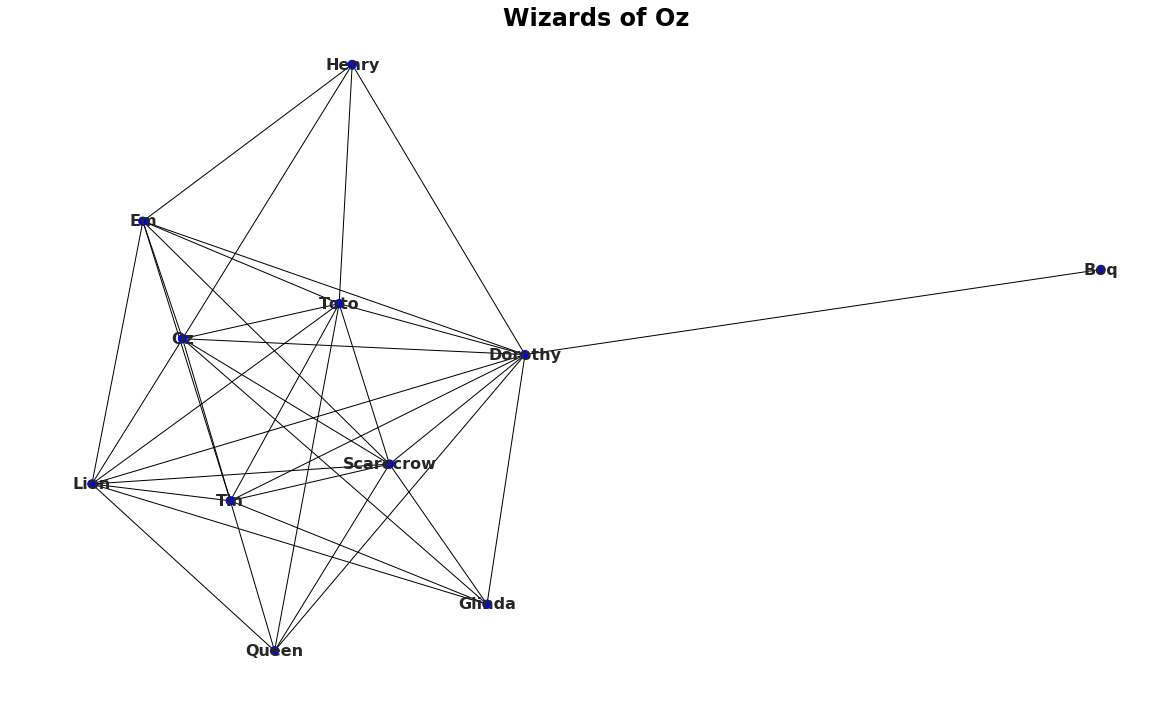

In [6]:
#Example with single text and single character list, as well as "custom" parameters
cast=["Dorothy","Boq","Oz","Tin","Lion","Queen","Scarecrow","Glinda","Henry","Em","Toto"]
text = open(os.path.expanduser("~/Downloads/WOOZ.txt")).read()
TextToNetwork(input_text = text, figures = cast, parms = [200,10], label = True, figdim = [20,12])

Please provide a title for the plot: WWII commanders in EAME and the Eastern Front


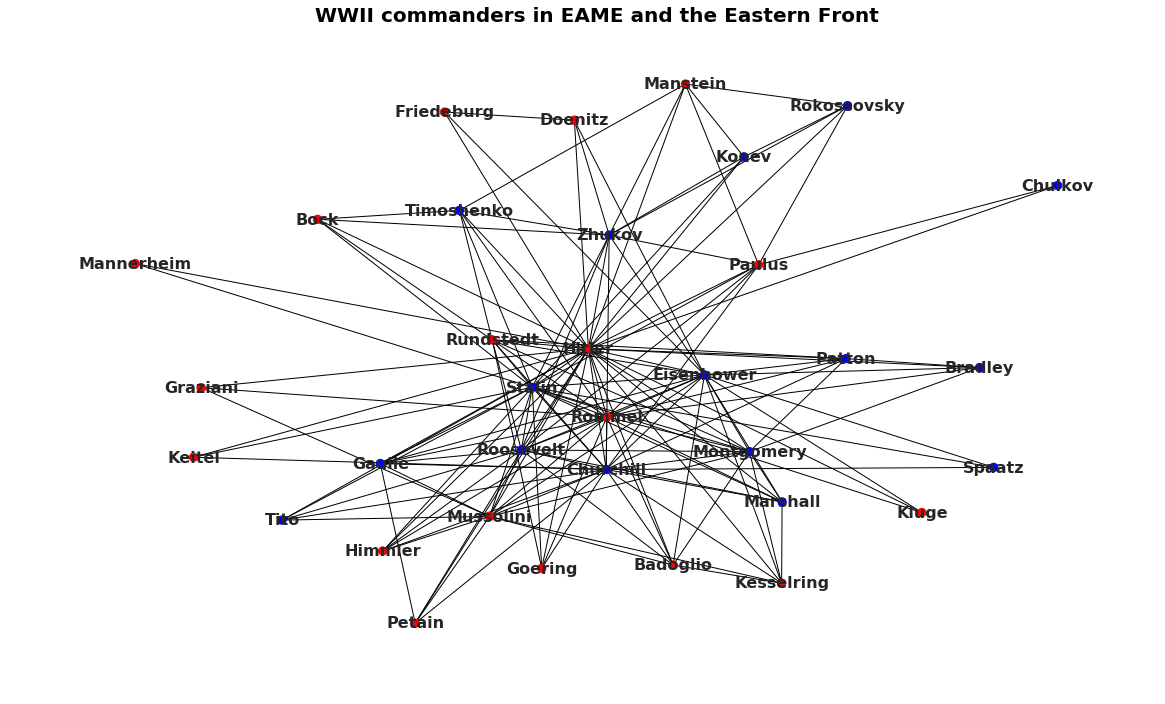

In [11]:
#Example with multiple texts and figure lists
text1 = open(os.path.expanduser("~/Downloads/worldwar2.txt")).read()
text2 = open(os.path.expanduser("~/Downloads/ww2_complete.txt")).read()
text3 = open(os.path.expanduser("~/Downloads/ww2_fuller.txt")).read()
text4 = open(os.path.expanduser("~/Downloads/ww2_sulzberger.txt")).read()
Allies = ["Roosevelt","Patton","Gaulle","Montgomery","Stalin","Churchill","Eisenhower","Bradley","Zhukov", "Konev",
         "Tito","Chuikov","Timoshenko","Marshall","Spaatz", "Rokossovsky"]
Axis = ["Hitler","Himmler","Mussolini","Rommel","Goering","Paulus","Petain","Mannerheim","Keitel","Rundstedt","Kluge",
        "Manstein","Kesselring","Badoglio","Graziani", "Bock","Friedeburg", "Doenitz"]
TextToNetwork((text1, text2, text3, text4), (Allies, Axis), label = True, fsize = 16)

Please provide a title for the plot: WWII Commanders in EAME and the Eastern Front


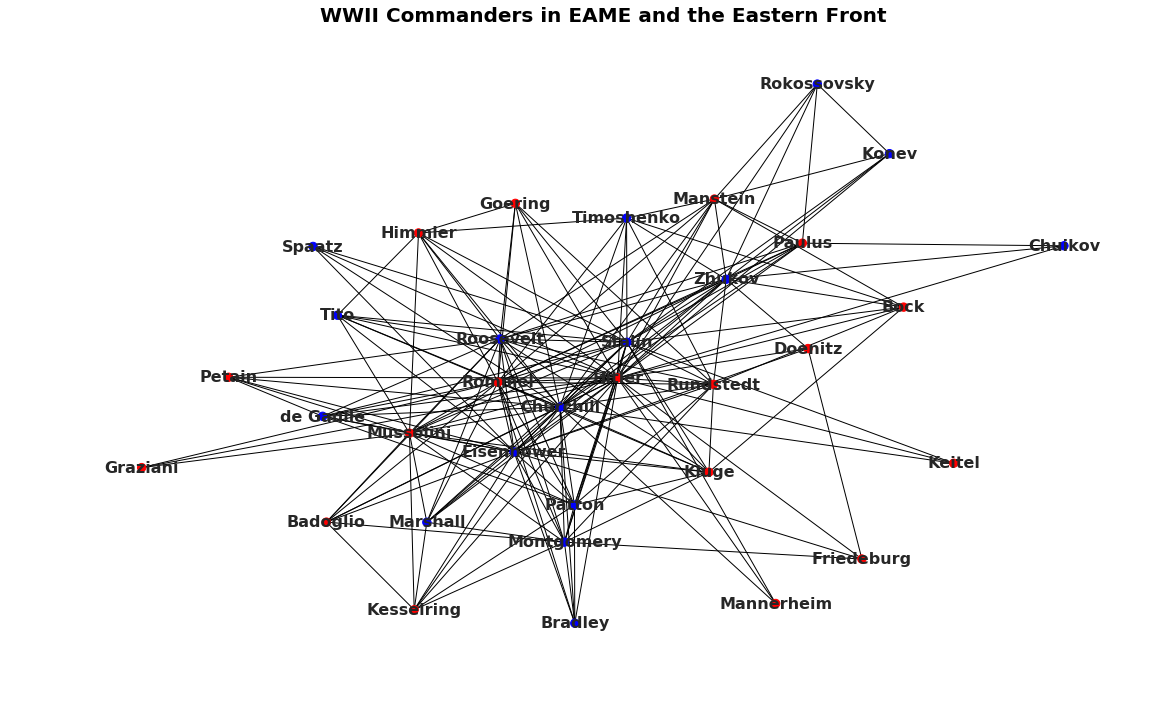

In [15]:
#same as above, but now we use regular expressions (recommended when there are spaces, such as "de Gaulle"):
Allies = ["Roosevelt","Patton","de Gaulle","Montgomery","Stalin","Churchill","Eisenhower","Bradley","Zhukov", "Konev",
         "Tito","Chuikov","Timoshenko","Marshall","Spaatz","Rokossovsky"]
Axis = ["Hitler","Himmler","Mussolini","Rommel","Goering","Paulus","Petain","Mannerheim","Keitel","Rundstedt","Kluge",
        "Manstein","Kesselring","Badoglio","Graziani","Bock","Friedeburg","Doenitz"]
TextToNetwork((text1, text2, text3, text4), (Allies, Axis), re_exp = True, label = True)

Please provide a title for the plot: Harry Potter Network


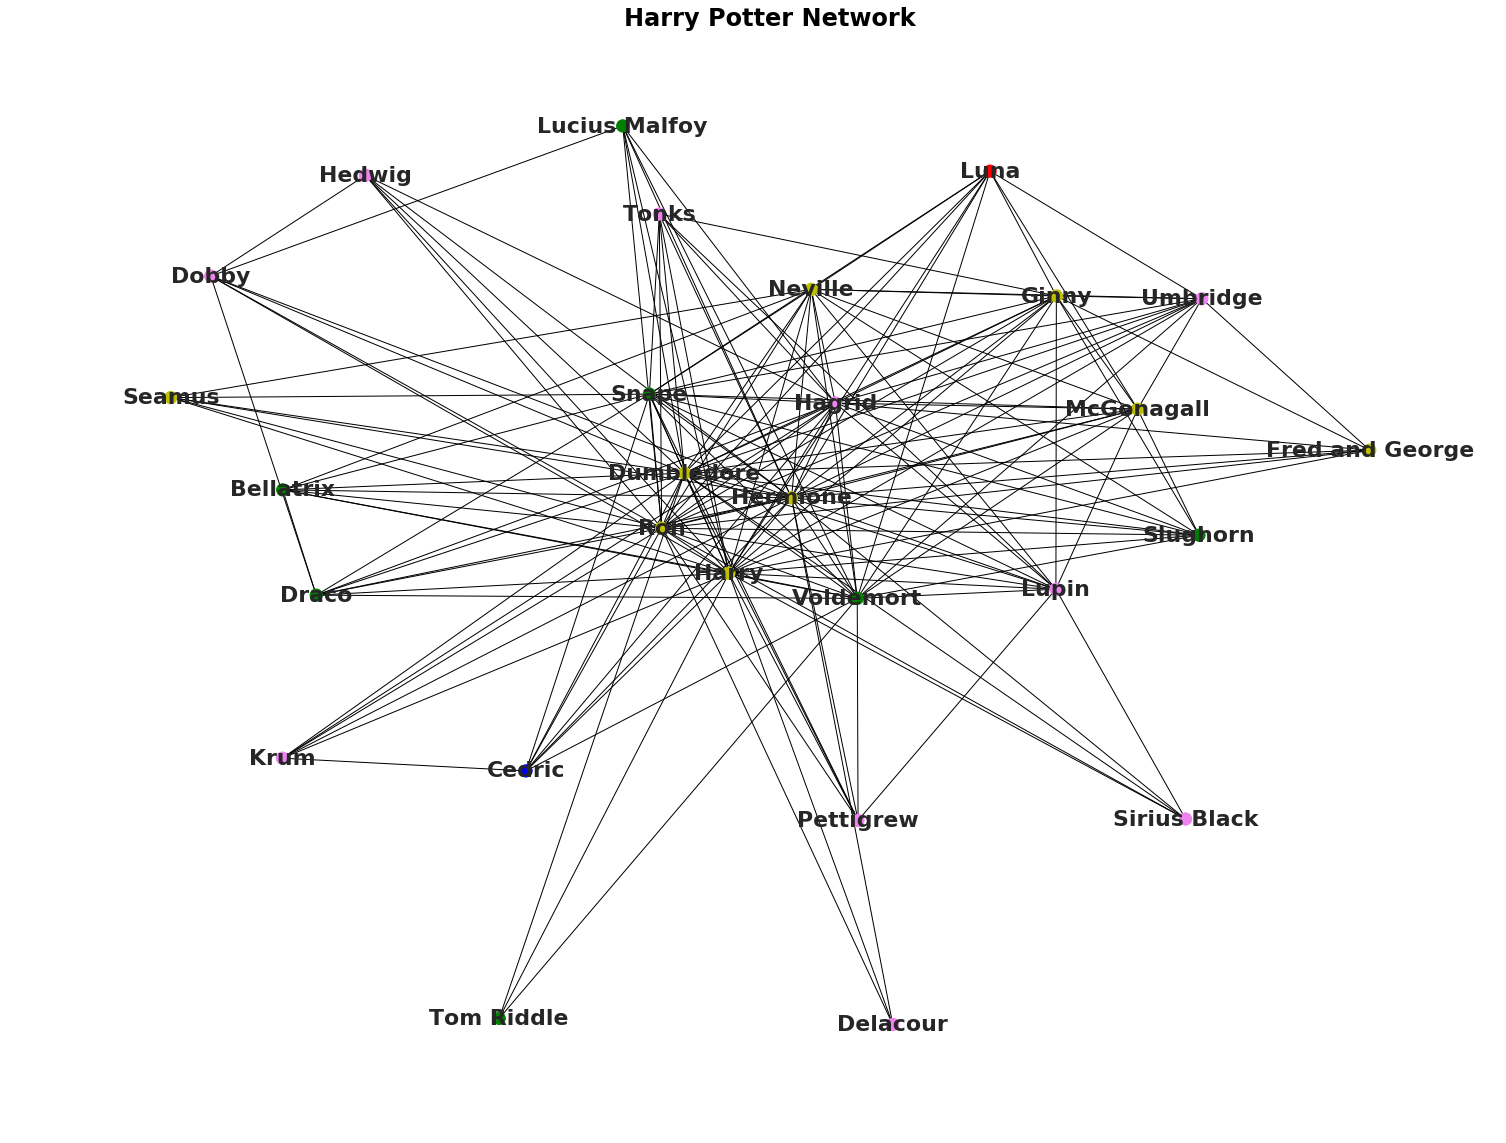

In [49]:
#Let's have a look at Harry Potter:
Hufflepuff = ["Cedric"]
Ravenclaw = ["Luna"]
Slytherins = ["Snape", "Voldemort", "Tom Riddle", "Bellatrix", "Lucius Malfoy", "Draco", "Slughorn"]
Gryffindor = ["Dumbledore", "Harry", "Hermione", "Ron", "Ginny", "Neville", "Seamus", "McGonagall", "Fred and George"]
Others = ["Hagrid", "Umbridge", "Krum", "Lupin", "Dobby", "Sirius Black", "Delacour", "Hedwig", "Pettigrew", "Tonks"]
book1 = open(os.path.expanduser("~/Downloads/HarryPotterDeathlyHollows.txt"), encoding ='cp1252').read()
book2 = open(os.path.expanduser("~/Downloads/HarryPotterTheHalfBloodPrince.txt"), encoding ='cp1252').read()
book3 = open(os.path.expanduser("~/Downloads/HarryPotterOrderofthePhoenix.txt"), encoding ='cp1252').read()
book4 = open(os.path.expanduser("~/Downloads/HarryPotterTheGobletOfFire.txt"), encoding = "Latin-1").read()
book5 = open(os.path.expanduser("~/Downloads/HarryPotterThePrisonerofAzkaban.txt"), encoding ='cp1252').read()
book6 = open(os.path.expanduser("~/Downloads/HarryPotterChamberofSecrets.txt"), encoding ='cp1252').read()
book7 = open(os.path.expanduser("~/Downloads/HarryPotterSorcerersStone.txt"), encoding ='cp1252').read()
TextToNetwork((book1, book2, book3, book4, book5, book6, book7), 
              (Hufflepuff, Ravenclaw, Slytherins, Gryffindor, Others), parms = [250, 70], re_exp = True, 
              figdim = [26,20], label = True, fsize = 22, nsize = 150)

In [1]:
#The following function is very similar to the first one. This time, I added an optional input to create weighted 
#graphs. The reason why I didn't replease the first function with this one, is because it hasn't been as thorougly
#tested as the one above.
#Inputs are the same as the first function, with the addition of weighted:
    #REQUIRED
    #- input_text: a .txt file (could be multiple)
    #- figures: a list of figures, or a list of lists of figures
    #OPTIONAL
    #- parms: two parameters used in deciding the relationship between the characters.
        #- the first one is the number of words two characters occur within
        #- the second one is the number of times that two characters have to be mentioned within n words in order 
            #to have a relationship between the two characters.
    #- label: whether the user wants to add a title to the graph
    #- re_exp: whether the user wants to use regular expressions (recommended whenever there are spaces in the figures)
    #- figdim: the dimensions of the graph
    #- fsize: font size of the labels
    #- nsize: the size of the nodes
    #- ewidth: the width of the edges
    #- weighted: wether you want the edges to be "weighted":
        #- if the user sets "weighted" to "True"(default), the weaker links (below average) will be displayed as 
            #dashed lines
        #- if the user sets "weighted" to "False", the output should be the same as the first function.
    

In [4]:
def WTextToNetwork(input_text, figures, parms = [500,10], label = False, re_exp = False, figdim = [20,12], fsize = 16, nsize = 70, ewidth = 0.5, weighted = True): 
    
    #Initializing an empty list for the key figures
    Key_figures = []
    #Initializing an empty dictionary
    mentioned = dict()
    #Initializin an empty dicitionary for the nodes
    Figure_nodes = dict()
    #Initializing the color_map and list for the different groups of the key figures
    color_map = []
    colors = ['b','r','g','y','violet','m','k','cyan','gold','dodgerblue']
    #Assigning the second parameter to "sens" (sensitivity)
    sens = parms[1]
    #Initializing list for edgestyle (weighted graph)
    edge_style = []
    #Initializing the overal sum and length in order to determine the average connection strength
    overall_sum = 0
    overall_len = 0
    
    #setting the size of the plot
    plt.rcParams["figure.figsize"] = (figdim[0],figdim[-1])
    
    #changing the data types of the inputs in case it's not a "list"
    if type(input_text) == str:
        input_text = [input_text]
    elif type(input_text) == tuple:
        input_text = list(input_text)

    if type(figures) == tuple:
        figures = list(figures)
        
    else:
        figures = [figures]
        
    #concatenating texts in case more than one texts are provided
    if len(input_text) > 1:
        text = ""
        for i in range(len(input_text)):
            text = text + " " + input_text[i]
    else:
        text = input_text[0]
        
    #cleaning up the text by replacing special characters with spaces
    text=text.replace(","," ")
    text=text.replace("."," ")
    text=text.replace("\n"," ")
    text=text.replace("'"," ")
    
    #adding the provided figures to the Key_figures list
    for i in range(len(figures)):
        for j in range(len(figures[i])):
            Key_figures.append(figures[i][j])
    #print(Key_figures)
    
    #filling the "mentioned" dictionary using regular expressions (the regular expression function will add the 
    #character index instead of the word index, which is why I multiply "wordsdiff" by 5 (the average length of a word))
    if re_exp == True:
        for figure in Key_figures:
            mentioned[figure] = [m.start(0) for m in re.finditer(r"\b" + figure + r"\b", text)]
        wordsdiff = parms[0]*5
        
    #Otherwise, the "mentioned" dictionary will be filled with word indexes using text splitting. 
    elif re_exp == False:
        #we start at the word with index '0'
        position=0
        #then, we iterate over the list of Key_figures and create an empty list inside the "mentioned" dictionary
        #for each figure
        for figure in Key_figures:
            mentioned[figure]=[]
        #if a word in the parsed text is one of the characters we're looking for: store the index
        for word in text.split(" "):
            if word in Key_figures:
                mentioned[word].append(position)
            #go to the next word (= increment index by 1)
            position+=1
        wordsdiff = parms[0]
    
    #for figure in Key_figures:
        #print(figure,len(mentioned[figure]))  
    
    #Using the first parameter, I will make a new dataframe, whose correspondig values will 
    #be incremented by one whenever two words are withing <wordsdiff> of eachother (this parameter is assigned
    #previous function)
    M = [[0]*len(Key_figures) for i in range(len(Key_figures))]
    #iterating over all possible combinations of figures/ characters
    for fig_a in Key_figures:
        for fig_b in Key_figures:
            #if the characters or not the same, and they occur within <wordsdiff> of eachother, add 1 to the "connectivity"
            #matrix (not a true connectivity matrix though)
            if fig_a!=fig_b:
                #print(fig_a,fig_b)
                for pos1 in mentioned[fig_a]:
                    for pos2 in mentioned[fig_b]:
                        if abs(pos1-pos2) < wordsdiff:
                            M[Key_figures.index(fig_a)][Key_figures.index(fig_b)]+=1                     
    
    #Using the second parameter, I will decide whether there is a tie or not by comparing
    #the values in M with the required sensitivity (e.g. if M[i[j]] > sens, there will be a tie)
    N = [[0]*len(M) for i in range(len(M))]
    #I iterate over the dataframe generated in the function above
    for row_ind in range(len(M)):
        for col_ind in range(len(M[row_ind])):
            #if two characters are mentioned withing <wordsdiff> words of eachother, at least <sens> times, there is
            #likely a relationship between the characters
            if M[row_ind][col_ind] >= sens:
                #in order to calculate the average connectivity strength, we need to store the sum of mentions, as well
                #as the total number of connections (this is only for the weighted edges)
                overall_sum += M[i][j]
                overall_len += 1
                N[row_ind][col_ind] = 1
    #calculating the overall mean (for the weighted edges)
    overall_mean = overall_sum/overall_len
    
    #Each node will be one of the key figures:
    for i in range(len(Key_figures)):
        Figure_nodes[i] = Key_figures[i] 
    #Creating an edge list E using the matrix N:
    E = MatrixToEdgeList(N) 
        
    #Initializing the NetworkX graph
    G = nx.erdos_renyi_graph(0,0)
    #Adding nodes to the NetworkX graph
    for figure in Figure_nodes.values():
        G.add_node(figure)
    #Adding edges to the NetworkX graph
    for i1, i2 in E:
        G.add_edge(Figure_nodes[i1], Figure_nodes[i2])
    
    #using the G.edges to ensure that the order for the edge_style assignment is correct
    EL = list(G.edges())
    #if the weighted parameter is set to "True":
    if weighted == True:
        #iterate over the edge list
        for edge in EL:
            #the edges corresponding to stronger than average connections will be plotted as solid lines "___"
            if M[Key_figures.index(edge[0])][Key_figures.index(edge[-1])] > overall_mean:
                edge_style.append('solid')
            #the edges corresponding to weaker than average connections will be plotted as dashed lines "--" 
            else:
                edge_style.append('dashed')  
    elif weighted == False:
        edge_style = ['solid']*len(EL)

    #Assigning colors to each group
    for node in G:
        for i in range(len(figures)):
            if node in figures[i]:
                color_map.append(colors[i])
    plt.figure(figsize=(20,12))
    #Adding a title to the plot (if desired)
    if label == True:
        title = input("Please provide a title for the plot: ")
        plt.title(title, fontsize = 24, fontweight = "bold")
    #Drawing the NetworkX graph:
    pos = nx.spring_layout(G)
    #Drawing the nodes:
    nx.draw_networkx_nodes(G, pos, node_color = color_map, node_size = nsize)
    #Drawing the labels:
    nx.draw_networkx_labels(G, pos, font_size = fsize, font_weight = "bold", font_color = '0.15')
    #Drawing the edges:
    nx.draw_networkx_edges(G, pos, width = ewidth, style = edge_style)
    #Turning the axis off (adds no value)
    plt.axis('off')
    #showing the plot
    plt.show()

Please provide a title for the plot: Wizards of Oz


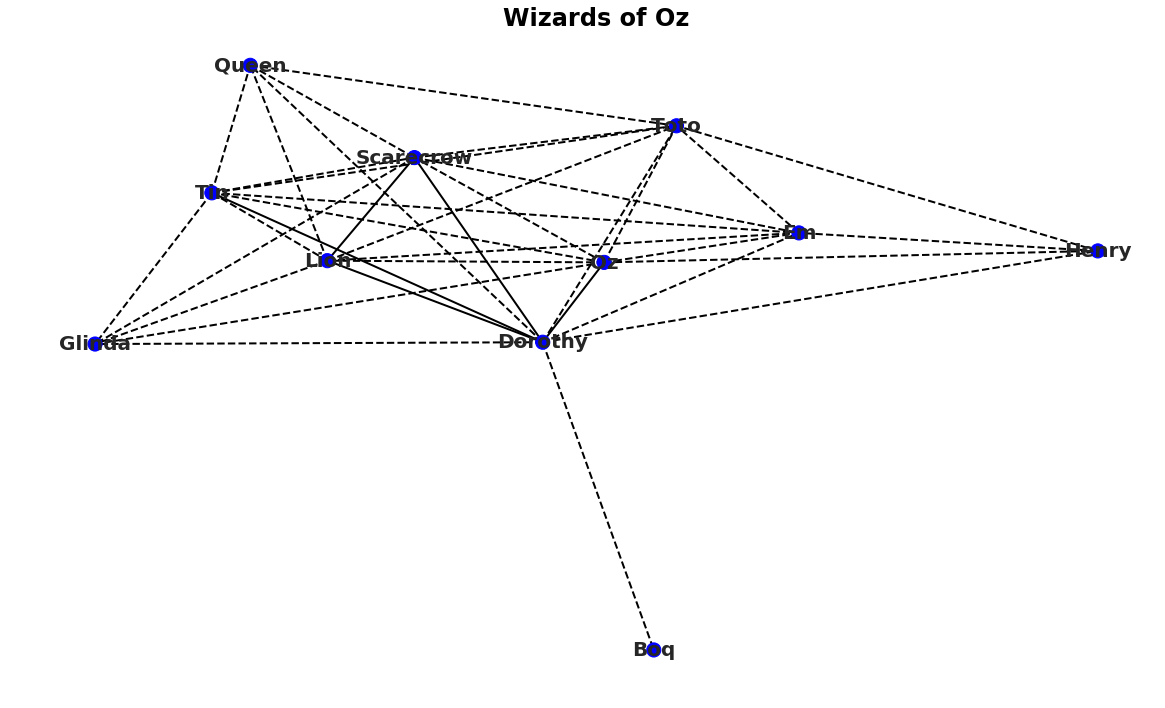

In [45]:
#First example (Wizards of Oz)
cast=["Dorothy","Boq","Oz","Tin","Lion","Queen","Scarecrow","Glinda","Henry","Em","Toto"]
text = open(os.path.expanduser("~/Downloads/WOOZ.txt")).read()
WTextToNetwork(input_text = text, figures = cast, parms = [200,10], fsize = 20, nsize = 200, 
               ewidth = 2, label = True, figdim = [20,12])

Please provide a title for the plot: WWII Commanders (weighted)


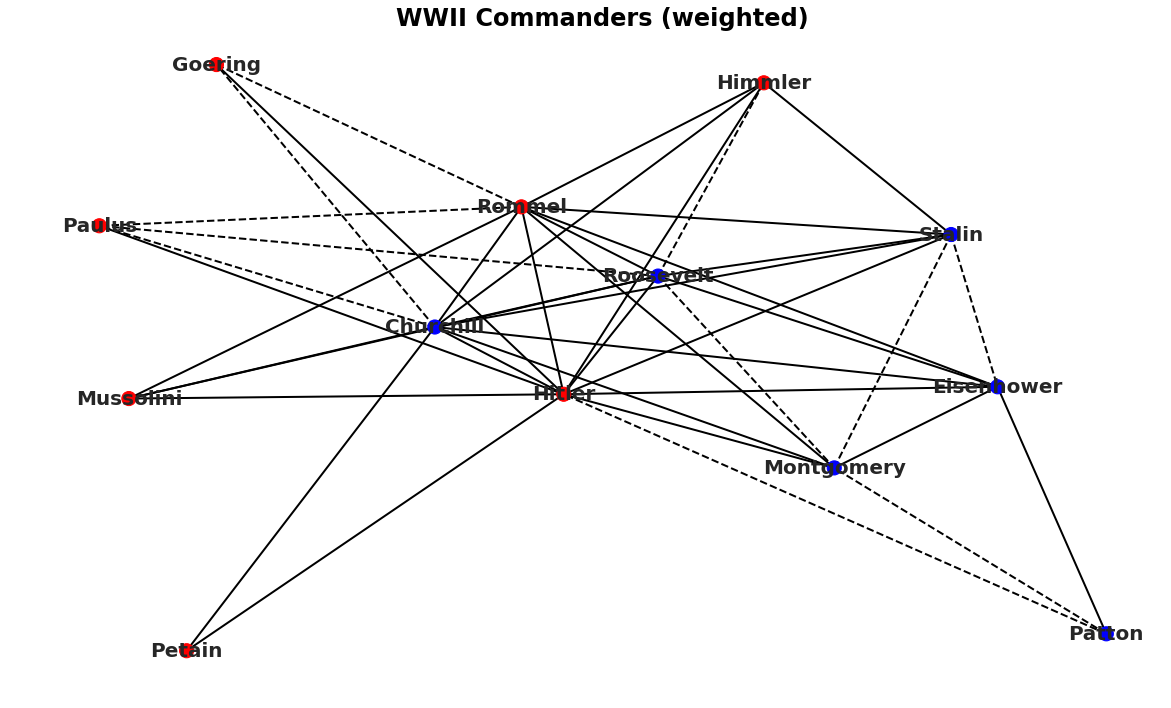

In [5]:
#Next, I will try the weighted network graph with a smaller version of the WWII commanders:
text1 = open(os.path.expanduser("~/Downloads/worldwar2.txt")).read()
text2 = open(os.path.expanduser("~/Downloads/ww2_complete.txt")).read()
text3 = open(os.path.expanduser("~/Downloads/ww2_fuller.txt")).read()
Allies = ["Roosevelt","Patton","Montgomery","Stalin","Churchill","Eisenhower"]
Axis = ["Hitler","Himmler","Mussolini","Rommel","Goering","Paulus","Petain"]
M = WTextToNetwork([text1, text2, text3], (Allies, Axis), parms = [700,20], fsize = 20, nsize = 200,
                   ewidth = 2, label = True, figdim = [20,12])

Please provide a title for the plot: WWII Commanders (not weighted)


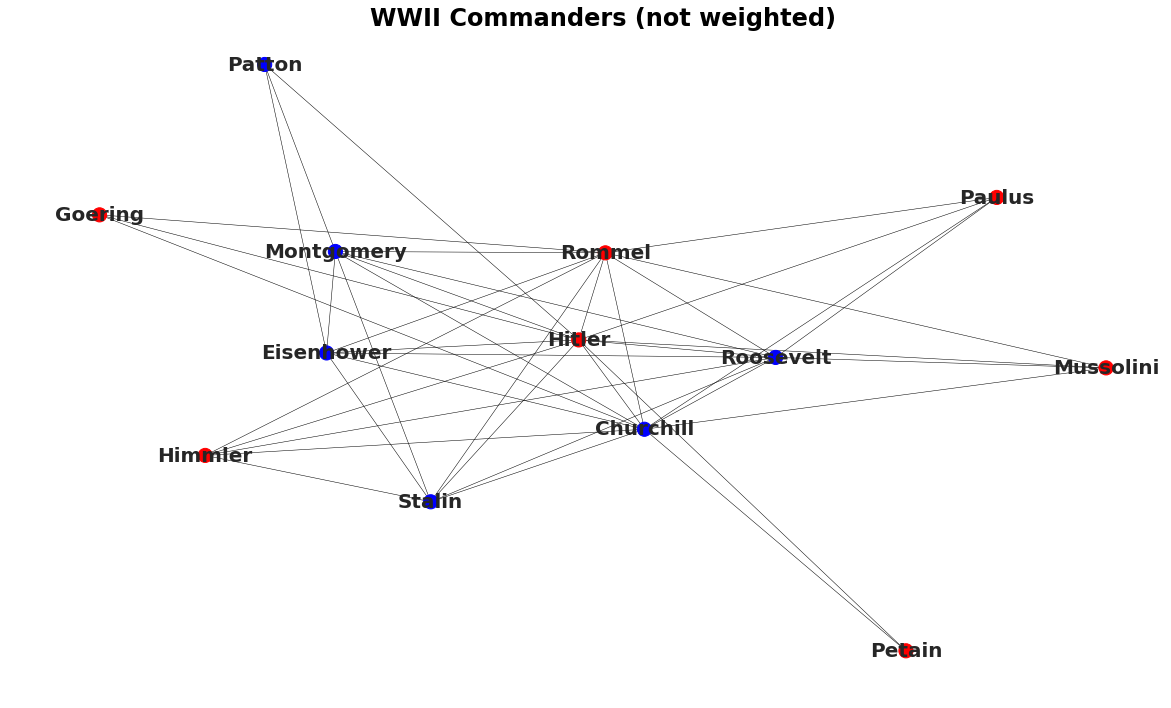

In [62]:
#Finally, I will try the weighted network graph with a smaller version of the WWII commanders, and weighted set to false:
text1 = open(os.path.expanduser("~/Downloads/worldwar2.txt")).read()
text2 = open(os.path.expanduser("~/Downloads/ww2_complete.txt")).read()
text3 = open(os.path.expanduser("~/Downloads/ww2_fuller.txt")).read()
Allies = ["Roosevelt","Patton","Montgomery","Stalin","Churchill","Eisenhower"]
Axis = ["Hitler","Himmler","Mussolini","Rommel","Goering","Paulus","Petain"]
M = WTextToNetwork([text1, text2, text3], (Allies, Axis), parms = [700,20], fsize = 20, nsize = 200,
                   label = True, figdim = [20,12], weighted = False)